# Implmenting "LivenessNet"

After excuting the `get_example_from_videos.py`, with skip=4, script I have the following image counts:

- **Fake:** 348 images
- **Real:** 294 images
- ***Total:*** 678 images

The next step is to implement “LivenessNet”, our deep learning-based liveness detector.

At the core, `LivenessNet`  is actually just a simple Convolutional Neural Network.

__We’ll be purposely keeping this network as shallow and with as few parameters as possible for two reasons:__

- To reduce the chances of overfitting on our small dataset.
- To ensure our liveness detector is fast, capable of running in real-time (even on resource-constrained devices, such as the Raspberry Pi).

Let’s get to the code: 

In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [19]:
class LivenessNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape 
        # and the channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same",
                        input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.25))
        
        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.25))
        
        # final set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(units=64))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(units=classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model
        

# Creating the liveness detector training script

We are now ready to train the network

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils
from imutils import paths
import numpy as np
import pickle
import cv2
import os

Let's define some paths

In [4]:
# path to input dataset
path_dataset = "dataset"

# path to where trained model should be stored
path_model = "liveness.model"

# path store label encoder
path_encoder = "le.pickle"

# path to store output loss/accuracy plot
path_plot = "plot.png"

The next block will perform some initilizations and build our data

In [31]:
# initialize initial learning rate, batch size , and the number of 
# epochs to train for
INIT_LR = 1e-4
BS = 8
EPOCHS = 100

In [12]:
# grab the list of images in our dataset directory, then initialize 
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(path_dataset))
data = []
labels = []

for image_path in imagePaths:
    # extract the class label from the filename, load the image and
    # resize it to be a fixed 32x32 pixels, ignoring aspect ratio
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (32,32))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0    
    

[INFO] loading images...


Let's encode the labels and partition the data

In [13]:
# encode the labels(strings) as ints and the one-hot-encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, 2)

# partition the data into training and testing splits using 75% of the
# data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                 test_size=0.25, random_state=42 )

In [14]:
trainX.shape

(481, 32, 32, 3)

In [15]:
testX.shape

(161, 32, 32, 3)

In [32]:
# construct the training image generator for the data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, 
                         width_shift_range=0.2, height_shift_range=0.2,
                        shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay= INIT_LR/EPOCHS)
model = LivenessNet.build(width=32, height=32, depth=3,
                         classes=len(le.classes_))
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


Let the training begin

In [33]:
# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX)//BS, 
    epochs=EPOCHS, verbose=1)

[INFO] training network for 100 epochs...
Epoch 1/100
60/60 [==============================] - 24s 395ms/step - loss: 0.9871 - acc: 0.5521 - val_loss: 0.4656 - val_acc: 0.8137
Epoch 2/100
60/60 [==============================] - 5s 88ms/step - loss: 0.9567 - acc: 0.6312 - val_loss: 0.4179 - val_acc: 0.8385
Epoch 3/100
60/60 [==============================] - 6s 94ms/step - loss: 0.7770 - acc: 0.6812 - val_loss: 0.3748 - val_acc: 0.8447
Epoch 4/100
60/60 [==============================] - 6s 96ms/step - loss: 0.7219 - acc: 0.6728 - val_loss: 0.3371 - val_acc: 0.8696
Epoch 5/100
60/60 [==============================] - 6s 92ms/step - loss: 0.6593 - acc: 0.7020 - val_loss: 0.3006 - val_acc: 0.9006A: 0s - loss: 0.6574 - acc: 0.
Epoch 6/100
60/60 [==============================] - 6s 96ms/step - loss: 0.5358 - acc: 0.7710 - val_loss: 0.3212 - val_acc: 0.8634oss: 0.5
Epoch 7/100
60/60 [==============================] - 6s 105ms/step - loss: 0.5955 - acc: 0.7312 - val_loss: 0.2913 - val_acc: 

After training is complete we can evluate its results and generate 
training plot

[INFO] evaluating network
              precision    recall  f1-score   support

        fake       1.00      0.96      0.98        95
        real       0.94      1.00      0.97        66

   micro avg       0.98      0.98      0.98       161
   macro avg       0.97      0.98      0.97       161
weighted avg       0.98      0.98      0.98       161

[INFO] serializing network to 'liveness.model'...


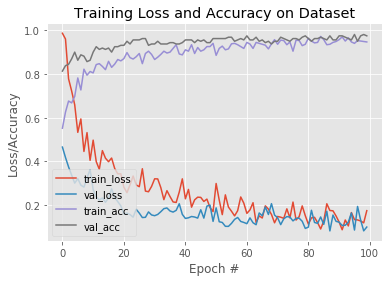

In [34]:
# evaluate the network
print("[INFO] evaluating network")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1),
                           target_names=le.classes_))

# save the model
print("[INFO] serializing network to '{}'...".format(path_model))
model.save(path_model)

# save the label encoder
f = open(path_encoder, "wb")
f.write(pickle.dumps(le))
f.close()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(path_plot)
plt.show()


Hurrah! accuracy is about 98% 

# Let's try it out

In [35]:
# import the necessary packages
from imutils.video import VideoStream
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import time
import cv2
import os

Define some paths and constants

In [36]:
# path to trained model
path_model = "liveness.model"

# path to label encoder
path_label_encoder = "le.pickle"

# path to face detection caffemodel
path_caffemodel = "..//DNN_MODELS//opencv_face_detector.caffemodel"

# path to face detection architecture
path_model_architecture = "..//DNN_MODELS//opencv_face_detector.prototxt"

# define min_confidence to filter out weak detections
min_confidence = 0.5

Let's load our models

In [45]:
# laod face detector
print("[INFO] loading face detector...")
net = cv2.dnn.readNetFromCaffe(path_model_architecture, path_caffemodel)

# load liveness detector
print("[INFO] loading liveness detector...")
model = load_model(path_model)
le = pickle.loads(open(path_label_encoder, 'rb').read())


[INFO] loading face detector...
[INFO] loading liveness detector...


Let's load up our test image and take a look before passing it through our network

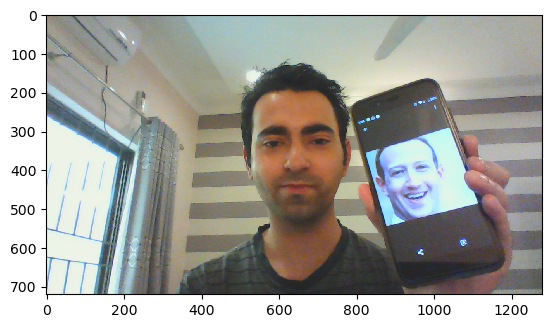

In [227]:
path_test_image = "test_img//test_img1.jpg"
plt.style.use('default')
test_img = cv2.imread(path_test_image)
# test_img = imutils.resize(test_img, width=600)
plt.imshow(test_img[...,::-1])
plt.show()

Let's begin with the liveness detection

In [228]:
# grab the img dims before we resize it for blob
(h, w) = test_img.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(test_img, (300, 300)), 1.0,
                                (300, 300), (104.0, 177.0, 123.0))
    
# pass the blob through the network and obtain detections 
# and predictions
net.setInput(blob)
detections = net.forward()

Now, we are ready to pass the detected faces through the LivenessNet

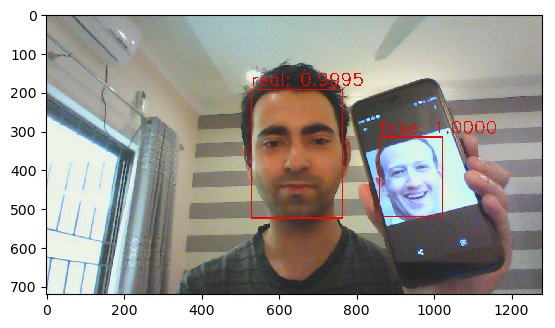

In [229]:
# plt.figure(figsize=(20,20))

# loop over the detections
for i in range(detections.shape[2]):
    # extract the confidence associated t=with the prediction
    confidence = detections[0, 0, i, 2]
    
    # filter out weak detections
    if confidence > min_confidence:
        # compute x,y - coordinates of the bounding box for the face
        # extract the ROI
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])   
        (startX, startY, endX, endY) = box.astype("int")
        
        # ensure detected bounding box does not fall outside the
        # image frame
        startX = max(0, startX)
        startY = max(0, startY)
        endX = min(w, endX)
        endY = min(h, endY)
            
        # extract the face ROI and then preproces it in the exact
        # same manner as our training data
        face = test_img[startY:endY, startX:endX]
        face = cv2.resize(face, (32, 32))
        face = face.astype("float") / 255.0
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)
        
        # pass the face through liveness detector to check if real or 
        # fake
        preds = model.predict(face)[0]
        j = np.argmax(preds)
        label = le.classes_[j]
        
        # draw the label and bounding box around the frame
        label = "{}: {:.4f}".format(label, preds[j])
        cv2.putText(test_img, label, (startX, startY-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
        cv2.rectangle(test_img, (startX, startY), (endX, endY), 
                     (0, 0, 255), 2)
        

plt.imshow(test_img[...,::-1])
plt.show()

__Check out `liveness_demo.py` for a realtime webcam based implementation__